# Xephyr library is loaded and you can use all classes and methods
### Now we are going to set up the SR0 likelihood.

In [1]:
.x loadXephyr.C

Info in <TUnixSystem::ACLiC>: creating shared library /home/pan/work/XEPHYR_PKG/Xephyr/notebooks/./../src/XeUtils_cxx.so
Info in <TUnixSystem::ACLiC>: creating shared library /home/pan/work/XEPHYR_PKG/Xephyr/notebooks/./../src/XeStat_cxx.so
Info in <TUnixSystem::ACLiC>: creating shared library /home/pan/work/XEPHYR_PKG/Xephyr/notebooks/./../src/dataHandler_cxx.so
Info in <TUnixSystem::ACLiC>: creating shared library /home/pan/work/XEPHYR_PKG/Xephyr/notebooks/./../src/XePdfObjects_cxx.so
Info in <TUnixSystem::ACLiC>: creating shared library /home/pan/work/XEPHYR_PKG/Xephyr/notebooks/./../src/XeLikelihoods_cxx.so
Info in <TUnixSystem::ACLiC>: creating shared library /home/pan/work/XEPHYR_PKG/Xephyr/notebooks/./../src/AsymptoticExclusion_cxx.so
Info in <TUnixSystem::ACLiC>: creating shared library /home/pan/work/XEPHYR_PKG/Xephyr/notebooks/./../src/ToyGenerator_cxx.so
Info in <TUnixSystem::ACLiC>: creating shared library /home/pan/work/XEPHYR_PKG/Xephyr/notebooks/./../src/ToyFitterExclusi

(int) 0



### We start from defining the input PDFs and their related uncertaintied:
this is done via a class called pdfComponent, its constructor take the following arguments:

```c++
pdfComponent::pdfComponent(TString name, TString filename) 
```

where "name" must be the prefix of the histogram from which you are loading this component, and "filename" is the file with its complete path.

**REMINDER:**
- The only supported histo name structure is the following:
- Must prefix_XXname_YY_name2_


In [2]:
errorHandler::globalPrintLevel = 1;  // print level 3 = Error only , 2 = Warning,  1= Info, 0 = Debug

In [3]:
TString ER_file = "data_examples/DMTemplatesReweighted_lax0.11.1_V12.root";
pdfComponent *ER = new pdfComponent("hband", ER_file);

In [4]:
 //Now some settings:
        ER->setScaleFactor(63.);                    // Set the normalization factor for ER in events.
        shapeSys *PY = new shapeSys("_PY");         // 
        PY->setStep(0.25);     
        PY->setMinimum(-2.);   
        PY->setMaximum(2.);    
//      PY->setType(FIXED_PARAMETER);
        shapeSys *RF = new shapeSys("_RF");
        RF->setStep(0.25);     
        RF->setMinimum(-2.);   
        RF->setMaximum(2.);    
//      RF->setType(FIXED_PARAMETER);
//      shapeSys *Thr = new shapeSys("_Threshold");
//      Thr->setStep(0.5);     
//      shapeSys *Ne = new shapeSys("_NexNi");
//      Ne->setStep(0.5);      
        scaleSys *s1 = new scaleSys("ERscale",0.12); 
        s1->setType(FREE_PARAMETER);
        ER->addScaleSys(s1);   
        ER->addShapeSys(PY);   
        ER->addShapeSys(RF);
        //ER->addShapeSys(Thr);
        //ER->addShapeSys(Ne); 

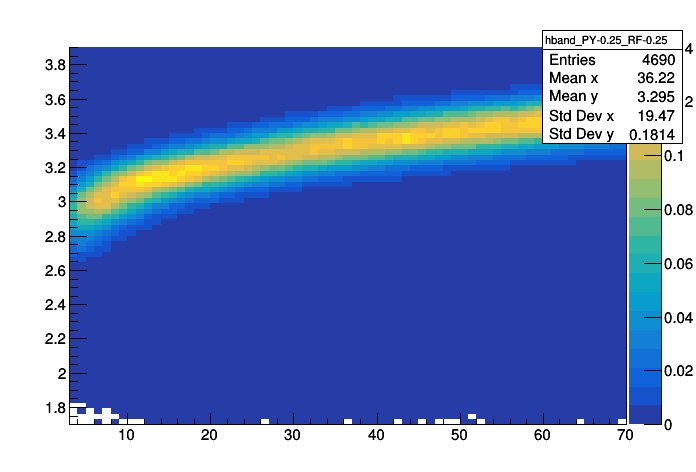

In [5]:
TCanvas *c = new TCanvas();
TH2F h = ER->getInterpolatedHisto();
h.Draw("colz");
c->Draw();

Now you couold for example change the value of one of the nuissance parameter and get the relative histogram interpolated... Let's do that!

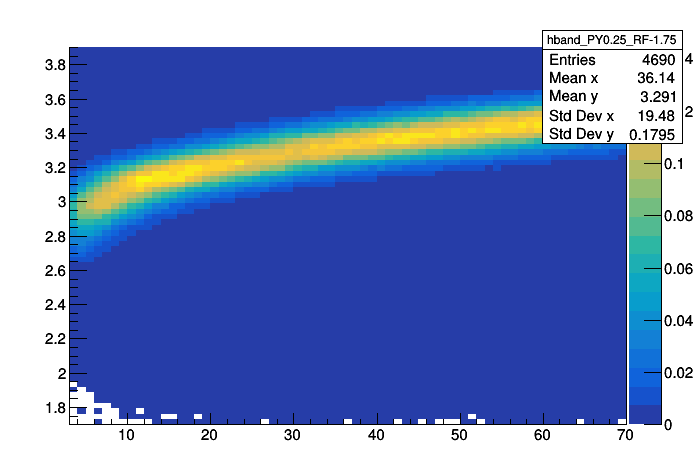

In [6]:
TCanvas *c2 = new TCanvas();
RF->setCurrentValue(-1.7);               // Setting the value of RF to -1.7 sigma from its standard value (rememer the value will be interpolated)
PY->setCurrentValue(0.35);
TH2F h2 = ER->getInterpolatedHisto();
h2.Draw("colz");
c2->Draw();

##### Now let's add a Signal PdfComponent

In [7]:
TString Signal_file ="data_examples/wimp_0050gev_variations_lax_0.11.1.root" ;
pdfComponent *Signal = new pdfComponent( "wimp_0050gev", Signal_file);

        Signal->setScaleFactor(34.2 * 1.0418);
        Signal->suffix= "sigma";

//        scaleSys *s2 = new scaleSys("scaleS",0.1);
//      Signal->addScaleSys(s2);

        shapeSys *Gamma = new shapeSys("_gamma_");
//      Gamma->setStep(0.5);
        shapeSys *Alpha = new shapeSys("_alpha_");  // OK
//      Alpha->setStep(0.5);
        shapeSys *Lambda = new shapeSys("_eta_");
//      Lambda->setStep(0.5);
//      shapeSys *Lambda = new shapeSys("_lambda_");
        shapeSys *ExEff = new shapeSys("_acceptance_par_");  //OK 
//      ExEff->setStep(0.5);
//      shapeSys *ExEff = new shapeSys("_extraction_efficiency_");

        Gamma->setType(FIXED_PARAMETER);
        //Alpha->setType(FIXED_PARAMETER);
        Lambda->setType(FIXED_PARAMETER);
        //ExEff->setType(FIXED_PARAMETER);

        Signal->addShapeSys(Gamma);
        Signal->addShapeSys(Alpha);
        Signal->addShapeSys(Lambda);
        Signal->addShapeSys(ExEff);


In [8]:
cout << Gamma->getName();

_gamma_

#### And let's draw it, just for fun...

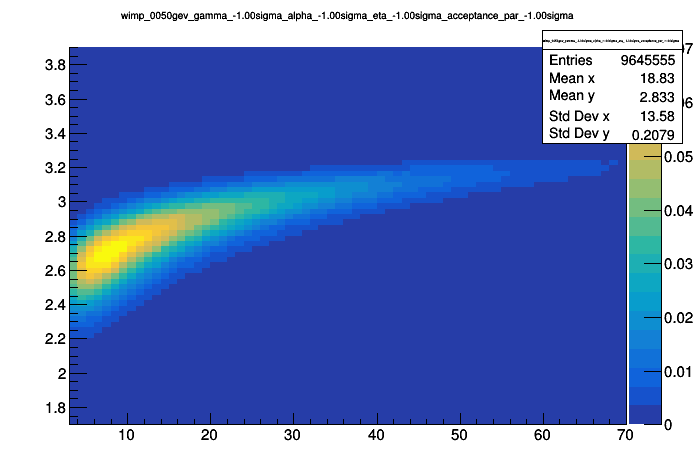

In [9]:
TCanvas *c3 = new TCanvas();
TH2F h3 = Signal->getInterpolatedHisto();
h3.Draw("colz");
c3->Draw();

#### Now let's add some data

In [10]:
TString data_filename = "data_examples/xephyr_data_none_lowenergy_roi.root";
TString data_treeName = "DMtree";
dataHandler *data = new dataHandler("dmData",data_filename, data_treeName);

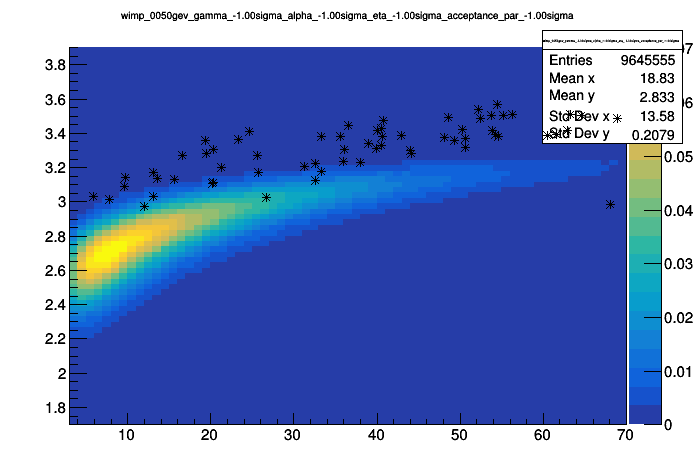

In [11]:
data->drawS1S2("same*");
c3->Draw();

# Now it's time for some likelihood game

In [12]:
pdfLikelihood pl("xe1T", 50);
pl.setExperiment(1);
//pl.addBkgPdfComponent(flat, true);
//pl.addBkgPdfComponent(radio, false);
//pl.addBkgPdfComponent(cnns, false);
//pl.addBkgPdfComponent(AC, false);
//pl.addBkgPdfComponent(wall, false);
pl.addBkgPdfComponent(ER, true);
pl.setSignalPdf(Signal);       
pl.setSignalDefaultNorm(1.E-45);
//pl.setPrintLevel(0);
pl.setDataHandler(data);       
  
//pl.setCalibrationData(radon220);
pl.setWithSafeGuard(false);    
//pl.setAdditionalSafeGuardComponent(ACforSafeguard);
  
pl.initialize();


pdfLikelihood - INFO: bkg component named hband added to    SAFEGUARDED
pdfLikelihood::initialize - INFO :  initialize..... 
	Likelihood::addParameter - Info : Adding parameter Sigma  with ID -1  to PL xe1T
INFO :  adding sys for BKG component hband
	Likelihood::addParameter - Info : Adding parameter ERscale  with ID 1  to PL xe1T
	Likelihood::addParameter - Info : Adding parameter _PY  with ID 2  to PL xe1T
	Likelihood::addParameter - Info : Adding parameter _RF  with ID 3  to PL xe1T
INFO :  adding sys for SIGNAL component wimp_0050gev
	Likelihood::addParameter - Info : Adding parameter _gamma_  with ID 4  to PL xe1T
	Likelihood::addParameter - Info : Adding parameter _alpha_  with ID 5  to PL xe1T
	Likelihood::addParameter - Info : Adding parameter _eta_  with ID 6  to PL xe1T
	Likelihood::addParameter - Info : Adding parameter _acceptance_par_  with ID 7  to PL xe1T

------ WARNING -------  Safeguard is turned OFF altough you have set components to be safeguarded this is ignored --

In [13]:
//pl.maximize(false);             
pl.printCurrentParameters(); 
//pl.printInitialParameters();

 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 ERscale              Free               0                 
  2 _PY                  Nuisance        0.35                 
  3 _RF                  Nuisance        -1.7                 
  4 _gamma_              Fixed              0                 
  5 _alpha_              Nuisance           0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Nuisance           0                 


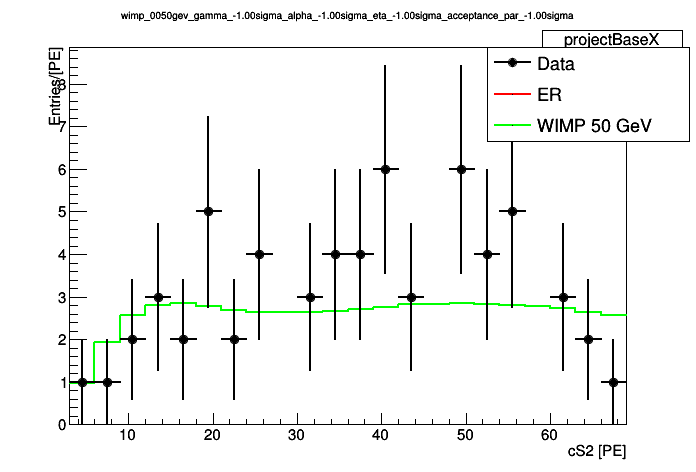

 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 ERscale              Free               0                 
  2 _PY                  Nuisance        0.35                 
  3 _RF                  Nuisance        -1.7                 
  4 _gamma_              Fixed              0                 
  5 _alpha_              Nuisance           0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Nuisance           0                 
Data   63
Bkg    63
Signal 0 POI 0  SignalMultiplier  0.0602386
...... That signal scaled is 0


Info in <TH1D::Add>: Attempt to add histograms with different bin limits - trying to use TH1::Merge


In [14]:
// class example to compare histograms
histoCompare p = pl.getModelCompare();
//p.setNameofComponent(1,"flat");
//p.setNameofComponent(1,"AC");
p.setNameofComponent(1,"ER");
p.setNameofComponent(2,"WIMP 50 GeV");
p.rebinY = 1;
p.rebinX = 3;
p.doStack = true;
p.titleY="Entries/[PE]";
p.titleX="cS2 [PE]";
p.projectionMin = 3;
p.projectionMax = 3.6;
p.projectionX = true;
//p.compareWithRatio();
TCanvas *c4 = new TCanvas();
p.compare();

c4->Draw();

In [15]:
AsymptoticExclusion as( &pl, 0.1);  // 0.1  --> means 90% CLs
  

  
//just compute the sensitivity 
//  as.computeSensitivity();
  
as.setNscanPoints(100);   // set the number of scan points for limit computation, the pvalues are computed in steps of the parameter of interest untill the CL is reached.
//as.setScanMax(100.);    // Set the range of the scan (default 3 sigma from expected sensitivity)
//as.setScanMin(0.);      // Set the range of the scan (default 0.) 
  
  
as.setQTilde(true);            

In [16]:
as.computeLimits();       // compute the sensitivity first then the CLs limit
  
//as.LikelihoodScan();
  
as.writeToFile("example_limit_"); 


 ------- START-------- 
 AsymptoticExclusion::unconditionalFit() 
Finding maximum of xe1T
Total of 6 active parameters, don't freeze parameters of interest, Minuit fits 6 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 ERscale              Free               0                 
  2 _PY                  Nuisance           0                 
  3 _RF                  Nuisance           0                 
  4 _gamma_              Fixed              0                 
  5 _alpha_              Nuisance           0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Nuisance           0                 
ML -231.566 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest     0.26 +- 2.5      
  1 ERscale              Free          -0.034 +- 1.5      
  2 _PY           

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -232.305 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.3                 
  1 ERscale              Free           -0.22 +- 1.5      
  2 _PY                  Nuisance       -0.25 +- 0.095    
  3 _RF                  Nuisance       -0.32 +- 1.3      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Nuisance     0.00021 +- 0.059    
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Nuisance    -0.00047 +- 0.14     
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.3                 
  1 ERscale              Free           -0.22                 
  2 _PY                  Nuisance       -0.25                 
  3 _RF                  Nuisance       -0.32                 
  4 _gamma_              Fixed              0                 
  5 _alpha_        

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -232.824 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           4.3                 
  1 ERscale              Free           -0.25 +- 1.4      
  2 _PY                  Nuisance       -0.25 +- 0.026    
  3 _RF                  Nuisance       -0.36 +- 0.54     
  4 _gamma_              Fixed              0                 
  5 _alpha_              Nuisance     0.00026 +- 0.042    
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Nuisance    -0.00018 +- 0.08     
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           4.3                 
  1 ERscale              Free           -0.25                 
  2 _PY                  Nuisance       -0.25                 
  3 _RF                  Nuisance       -0.36                 
  4 _gamma_              Fixed              0                 
  5 _alpha_        

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -232.555 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.8                 
  1 ERscale              Free           -0.24 +- 1.5      
  2 _PY                  Nuisance       -0.25 +- 0.077    
  3 _RF                  Nuisance       -0.34 +- 1.3      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Nuisance     7.5e-05 +- 0.12     
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Nuisance    -0.00025 +- 0.014    
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.8                 
  1 ERscale              Free           -0.24                 
  2 _PY                  Nuisance       -0.25                 
  3 _RF                  Nuisance       -0.34                 
  4 _gamma_              Fixed              0                 
  5 _alpha_        

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -232.305 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.3                 
  1 ERscale              Free           -0.22 +- 1.5      
  2 _PY                  Nuisance       -0.25 +- 0.095    
  3 _RF                  Nuisance       -0.32 +- 1.3      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Nuisance     0.00021 +- 0.059    
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Nuisance    -0.00047 +- 0.14     
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.3                 
  1 ERscale              Free           -0.22                 
  2 _PY                  Nuisance       -0.25                 
  3 _RF                  Nuisance       -0.32                 
  4 _gamma_              Fixed              0                 
  5 _alpha_        

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -232.428 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.5                 
  1 ERscale              Free           -0.23 +- 1.5      
  2 _PY                  Nuisance       -0.25 +- 0.061    
  3 _RF                  Nuisance       -0.33 +- 1.3      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Nuisance     4.4e-05 +- 0.065    
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Nuisance    -0.00024 +- 0.051    
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.5                 
  1 ERscale              Free           -0.23                 
  2 _PY                  Nuisance       -0.25                 
  3 _RF                  Nuisance       -0.33                 
  4 _gamma_              Fixed              0                 
  5 _alpha_        

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -232.397 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.4                 
  1 ERscale              Free           -0.23 +- 1.4      
  2 _PY                  Nuisance       -0.25 +- 0.0049   
  3 _RF                  Nuisance       -0.33 +- 1.3      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Nuisance     0.00059 +- 0.0005   
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Nuisance    -6.3e-05 +- 0.043    
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.4                 
  1 ERscale              Free           -0.23                 
  2 _PY                  Nuisance       -0.25                 
  3 _RF                  Nuisance       -0.33                 
  4 _gamma_              Fixed              0                 
  5 _alpha_        

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -232.381 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.4                 
  1 ERscale              Free           -0.23 +- 1.5      
  2 _PY                  Nuisance       -0.25 +- 0.049    
  3 _RF                  Nuisance       -0.33 +- 1.3      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Nuisance     1.4e-05 +- 0.062    
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Nuisance    -0.00073 +- 0.2      
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.4                 
  1 ERscale              Free           -0.23                 
  2 _PY                  Nuisance       -0.25                 
  3 _RF                  Nuisance       -0.33                 
  4 _gamma_              Fixed              0                 
  5 _alpha_        

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -232.389 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.4                 
  1 ERscale              Free           -0.23 +- 1.4      
  2 _PY                  Nuisance       -0.25 +- 0.039    
  3 _RF                  Nuisance       -0.33 +- 1.2      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Nuisance     0.00013 +- 0.052    
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Nuisance    -0.00015 +- 0.057    
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.4                 
  1 ERscale              Free           -0.23                 
  2 _PY                  Nuisance       -0.25                 
  3 _RF                  Nuisance       -0.33                 
  4 _gamma_              Fixed              0                 
  5 _alpha_        

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max
Warning in <TFile::Append>: Replacing existing TH1: pullsHisto (Potential memory leak).


# If you go at the bottom of the previous print out you'll see the result:
```
OBSERVED limit not scaled mu 3.42441  cross section no cLS 2.06282e-46  test stat value no cls -999  cross section  2.06282e-46  test stat value -999
```

The important number is cross section no CLs 2.06e-46 cm^2